# <span style="color:Maroon">Short Term XgBoost Model

__Summary:__ <span style="color:Blue">In this code we shall build and test a short term XgBoost Model using Technical Indicators

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import ta
import pickle
from sklearn.model_selection import KFold, GridSearchCV
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report
from scipy import interp
np.random.seed(0)

In [2]:
# User defined names
index = "Gold"
filename = index+"_hurst_segment_dependent.csv"
date_col = "Date"

# Declare the hyper-parameters for grid search
learning_rate = [0.02, 0.05, 0.1]
n_estimators = [100, 200, 300]
subsample = [0.6, 0.7]
max_features = ['auto', 'sqrt']
max_depth = [3, 5]
min_samples_split = [0.02, 0.10]
min_samples_leaf = [0.01, 0.05]

In [3]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\sidhu\Downloads\Course 10 Capstone Project\Trading Strategy Development\Dev\Gold\Codes


In [4]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [5]:
# Read the data
df = pd.read_csv(filename, index_col=date_col)
df.index = pd.to_datetime(df.index)
df.head()

,High,Low,Open,Close,Volume,Adj Close,hurst_100,hurst_150,hurst_200,hurst_250,...,Increasing days,Decreasing days,Zero Cross Neg,Zero Cross Pos,Zero Cross Total,Ratio Trend,Ratio Zero,Segment,DVT STD,Target
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,138.770004,137.720001,137.779999,138.720001,9219800,138.720001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-03,139.000000,137.880005,138.669998,138.000000,11510200,138.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-04,136.279999,134.160004,136.240005,134.750000,26154300,134.750000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-05,134.679993,133.100006,133.500000,134.369995,16700900,134.369995,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0
2011-01-06,134.380005,133.139999,134.050003,133.830002,15965300,133.830002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mean Reverting,NaN,0


## <span style="color:Maroon">Functions

In [6]:
def Split_data_XY(df, dv):
    """
    Given a dataset returns two dataframes, X-Dataframe and y-dataframe
    """
    X_df = df.drop([dv], axis=1)
    y_df = df[dv]
    y_labelizer = label_binarize(y_df, classes=[-1, 0, 1])
    return X_df, y_df, y_labelizer

In [7]:
def Get_Max_Discretevar(df, var, window=10):
    """
    Get maximum value on rolling basis for the variable
    """
    df[var+"_max"+str(window)] = df[var].rolling(window=window).max()
    return df

In [8]:
def Get_SMA_Continousvar(df, var, window=10):
    """
    Get SMA for continous variable
    """
    df[var+"_sma"+str(window)] = df[var].rolling(window=window).mean()
    return df

In [9]:
def Get_Ratio_Continousvar(df, var, window=10):
    """
    Get Ratio for continous variable Min/Max
    """
    df[var+"_ratio_minmax"+str(window)] = np.where(np.abs(df[var].rolling(window=window).max()) > 0, 
                                                   df[var].rolling(window=window).min()/
                                                   df[var].rolling(window=window).max(),0)
    return df

In [10]:
def Get_std_Continousvar(df, var, window=30):
    """
    Get Ratio for continous variable Min/Max
    """
    df[var+"_std"+str(window)] = df[var].rolling(window=window).std()
    return df

In [11]:
def Generate_Predicted_df(X_train, y_train, X_test, y_test, clf):
    """
    Generates Pandas dataframe with predicted values and other columns for P&L analysis
    """
    # Train Sample
    df_train = pd.DataFrame(y_train)
    df_train['Predicted'] = clf.predict(X_train)
    df_train['Adj Close'] = X_train['Adj Close']
    df_train['Open'] = X_train['Open']
    df_train['DVT STD'] = X_train['DVT STD']
    df_train["Sample"] = "Train"
    # Test Sample
    df_test = pd.DataFrame(y_test)
    df_test['Predicted'] = clf.predict(X_test)
    df_test['Adj Close'] = X_test['Adj Close']
    df_test['Open'] = X_test['Open']
    df_test['DVT STD'] = X_test['DVT STD']
    df_test['Sample'] = "Test"
    df = df_train.append(df_test)
    return df

## <span style="color:Maroon">Feature Engineering

In [12]:
# Add all technical features
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Adj Close", volume="Volume")

In [13]:
# Max variable list
max_vars = ['volatility_bbhi', 'volatility_bbli', 'volatility_kchi', 'volatility_kcli', 'trend_psar_up_indicator', 
            'trend_psar_down_indicator']
for i in range(0, len(max_vars)):
    df = Get_Max_Discretevar(df, max_vars[i], 10)

In [14]:
# SMA variable list
sma_vars = ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
            'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm', 'volatility_bbh', 
            'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 
            'volatility_kcw', 'volatility_kcp', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 
            'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 
            'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 
            'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 
            'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv', 
            'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 
            'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_stc', 
            'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
            'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
            'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr', 'others_dlr', 
            'others_cr']
for i in range(0, len(sma_vars)):
    df = Get_SMA_Continousvar(df, sma_vars[i], window=10)

In [15]:
# Ratio of Min Max variables
for i in range(0, len(sma_vars)):
    df = Get_Ratio_Continousvar(df, sma_vars[i], window=10)

In [16]:
# Ratio of std variables
for i in range(0, len(sma_vars)):
    df = Get_std_Continousvar(df, sma_vars[i], window=30)

In [17]:
# Drop two features
df = df.drop(['trend_psar_down', 'trend_psar_up'], axis=1)
df = df[df['hurst_200'] > 0]
df.shape

(2319, 341)

In [18]:
# Drop rows with null values
df.dropna(inplace=True)
df.shape

(2119, 341)

## <span style="color:Maroon">Divide the data in Segments

In [19]:
df['Segment'].value_counts()

Mean Reverting    1278
Trending           841
Name: Segment, dtype: int64

In [20]:
# Break dataset into three segments
df_MeanReverting = df[df['Segment'] == "Mean Reverting"]
df_Trending = df[df['Segment'] == "Trending"]

In [21]:
# Drop Segment variable from all datasets
df.drop("Segment", axis=1, inplace=True)
df_MeanReverting.drop("Segment", axis=1, inplace=True)
df_Trending.drop("Segment", axis=1, inplace=True)

#### <span style="color:Maroon">Mean Reverting Dataset

In [22]:
# Divide dataset into Train and Test Sample. (5 Fold CV will be used for validation)
df_MeanReverting_Train = df_MeanReverting[df_MeanReverting.index.year <= 2018]
df_MeanReverting_Test = df_MeanReverting[df_MeanReverting.index.year > 2018]
print("Train Sample: ", df_MeanReverting_Train.shape)
print("Test Sample: ", df_MeanReverting_Test.shape)

Train Sample:  (1197, 340)
Test Sample:  (81, 340)


#### <span style="color:Maroon">Trending Dataset

In [23]:
df_Trending_Train = df_Trending[df_Trending.index.year <= 2018]
df_Trending_Test = df_Trending[df_Trending.index.year > 2018]
print("Train Sample: ", df_Trending_Train.shape)
print("Test Sample: ", df_Trending_Test.shape)

Train Sample:  (417, 340)
Test Sample:  (424, 340)


#### <span style="color:Maroon">Whole Dataset

In [24]:
df_Train = df[df.index.year <= 2018]
df_Test = df[df.index.year > 2018]
print("Train Sample: ", df_Train.shape)
print("Test Sample: ", df_Test.shape)

Train Sample:  (1614, 340)
Test Sample:  (505, 340)


## <span style="color:Maroon">GBM Model Random Grid Search

In [25]:
# grid 
grid = {'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'subsample': subsample,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf}

In [26]:
# GBM Model
scoring = {'Accuracy':make_scorer(balanced_accuracy_score)}
kfold = KFold(n_splits=3)
clf = GradientBoostingClassifier()
# Define grid search
grid = GridSearchCV(estimator = clf, param_grid=grid, cv=kfold, scoring=scoring, refit='Accuracy', verbose=1, n_jobs=-1)

#### <span style="color:Maroon">Whole Dataset

In [27]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_Test, 'Target')

In [28]:
# Fit the grid search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 115.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 119.3min finished


In [29]:
# Get the best gbm model based on Grid Search
best_gbm = model.best_estimator_
best_gbm

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.01, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [30]:
# GBM model selected using Grid search
clf = best_gbm
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.01, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [31]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [32]:
# Save the model
with open('whole_dataset'+str(index)+'_gbm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('whole_dataset'+str(index)+'_gbm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [33]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       1.00      0.95      0.97       309
           0       0.98      1.00      0.99       817
           1       1.00      0.99      0.99       488

    accuracy                           0.99      1614
   macro avg       0.99      0.98      0.99      1614
weighted avg       0.99      0.99      0.99      1614



In [34]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,294,14,1
0,0,816,1
1,1,3,484


In [35]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.23      0.57      0.32        76
           0       0.60      0.57      0.59       235
           1       0.49      0.23      0.31       194

    accuracy                           0.44       505
   macro avg       0.44      0.46      0.41       505
weighted avg       0.50      0.44      0.44       505



In [36]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,43,22,11
0,65,134,36
1,83,66,45


In [37]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [38]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

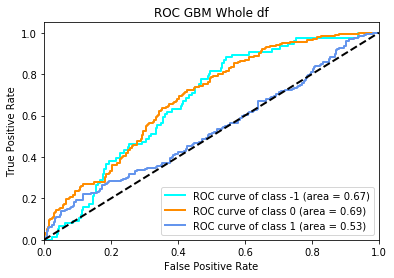

In [39]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GBM Whole df')
plt.legend(loc="lower right")
plt.savefig("gbm Whole test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [40]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [41]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('whole_dataset'+str(index)+'_gbm_model.csv', index=True)

#### <span style="color:Maroon">Trending Dataset

In [42]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_Trending_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_Trending_Test, 'Target')

In [43]:
# Fit the search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 28.3min finished


In [44]:
# Get the best gbm model based on Grid Search
best_gbm = model.best_estimator_
best_gbm

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.01, min_samples_split=0.02,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [45]:
# GBM model selected using Grid search
clf = best_gbm
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.01, min_samples_split=0.02,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [46]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [47]:
# Save the model
with open('Trending_dataset'+str(index)+'_gbm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('Trending_dataset'+str(index)+'_gbm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [48]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        73
           0       1.00      1.00      1.00       221
           1       1.00      1.00      1.00       123

    accuracy                           1.00       417
   macro avg       1.00      1.00      1.00       417
weighted avg       1.00      1.00      1.00       417



In [49]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,73,0,0
0,0,221,0
1,0,0,123


In [50]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.20      0.68      0.31        71
           0       0.64      0.44      0.52       198
           1       0.44      0.14      0.21       155

    accuracy                           0.37       424
   macro avg       0.42      0.42      0.35       424
weighted avg       0.49      0.37      0.37       424



In [51]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,48,15,8
0,92,87,19
1,99,35,21


In [52]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [53]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

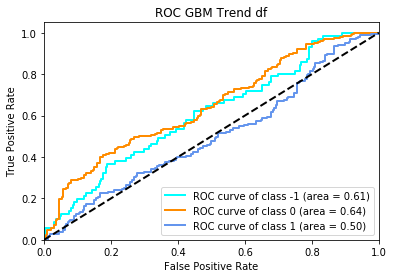

In [54]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GBM Trend df')
plt.legend(loc="lower right")
plt.savefig("gbm Trending test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [55]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [56]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('Trending_dataset'+str(index)+'_gbm_model.csv', index=True)

#### <span style="color:Maroon">No Trend Dataset

In [57]:
# Get X, Y variables
X_train, y_train, y_train_label = Split_data_XY(df_MeanReverting_Train, 'Target')
X_test, y_test, y_test_label = Split_data_XY(df_MeanReverting_Test, 'Target')

In [58]:
# Fit the search model
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 92.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 96.4min finished


In [59]:
# Get the best gbm model based on Grid Search
best_gbm = model.best_estimator_
best_gbm

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.05, min_samples_split=0.02,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [60]:
# GBM model selected using Grid search
clf = best_gbm
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.05, min_samples_split=0.02,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [61]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [62]:
# Save the model
with open('MeanReverting_dataset'+str(index)+'_gbm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# load it
with open('MeanReverting_dataset'+str(index)+'_gbm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [63]:
y_train_out = clf.predict(X_train)
print(classification_report(y_train, y_train_out))

              precision    recall  f1-score   support

          -1       1.00      0.97      0.98       236
           0       0.98      1.00      0.99       596
           1       1.00      0.99      0.99       365

    accuracy                           0.99      1197
   macro avg       0.99      0.98      0.99      1197
weighted avg       0.99      0.99      0.99      1197



In [64]:
# Confusion Matrix Train Sample
print("Train Sample Confusion Matrix")
pd.crosstab(y_train, y_train_out, rownames=['Actual'], colnames=['Predicted'])

Train Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,228,8,0
0,0,595,1
1,1,3,361


In [65]:
y_test_out = clf.predict(X_test)
print(classification_report(y_test, y_test_out))

              precision    recall  f1-score   support

          -1       0.21      0.60      0.32         5
           0       0.58      0.78      0.67        37
           1       0.65      0.28      0.39        39

    accuracy                           0.53        81
   macro avg       0.48      0.56      0.46        81
weighted avg       0.59      0.53      0.51        81



In [66]:
# Confusion Matrix Train Sample
print("Test Sample Confusion Matrix")
pd.crosstab(y_test, y_test_out, rownames=['Actual'], colnames=['Predicted'])

Test Sample Confusion Matrix


Predicted,-1,0,1
Actual,,,
-1,3,0,2
0,4,29,4
1,7,21,11


In [67]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")

In [68]:
y_score = clf.predict_proba(X_test)
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

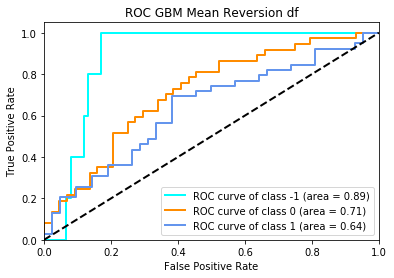

In [69]:
lw = 2

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

classes = [-1,0,1]
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GBM Mean Reversion df')
plt.legend(loc="lower right")
plt.savefig("gbm MeanReverting test" + str(index)+ " ROC curve"+'.png')
plt.show()

In [70]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [71]:
df_out = Generate_Predicted_df(X_train, y_train, X_test, y_test, clf)
df_out.to_csv('MeanReverting_dataset'+str(index)+'_gbm_model.csv', index=True)